<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import re
from datetime import datetime
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../../data/user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    file_names = glob(os.path.join(path_to_csv_files, '*.csv'))
    file_names.sort()

    with open(site_freq_path, "rb") as site_freq_pkl:
        sites_dictionary = pickle.load(site_freq_pkl)

    data_rows = []
    for file_name in file_names:
        user_id = int(re.findall('user(\d+).csv', file_name)[0])

        with open(file_name, 'r') as file:
            file_lines = list(filter(lambda x: ',' in x, map(lambda x: x.strip(), file.readlines())))[1:]
            line_number = 0
            while line_number < len(file_lines):
                data_row = [0] * len(feature_names)
                data_row[len(feature_names) - 1] = user_id

                i = 0
                session_start_time = None
                session_end_time = None
                while (line_number + i) < len(file_lines) and i < session_length:
                    file_line = file_lines[line_number + i].split(',')
                    operation_time = datetime.strptime(file_line[0], "%Y-%m-%d %H:%M:%S")
                    site_name = file_line[1]

                    if (session_start_time is None) or (session_start_time > operation_time):
                        session_start_time = operation_time
                    if (session_end_time is None) or (session_end_time < operation_time):
                        session_end_time = operation_time

                    data_row[i] = sites_dictionary[site_name][0]
                    i += 1

                if data_row[0] != 0:
                    data_row[session_length] = int((session_end_time - session_start_time).total_seconds())
                    data_row[session_length + 1] = len(set(filter(lambda x: x != 0, data_row[:session_length])))
                    data_row[session_length + 2] = session_start_time.hour
                    data_row[session_length + 3] = session_start_time.weekday()
                    data_rows.append(data_row)

                line_number += window_size

    return pd.DataFrame(data_rows, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                              feature_names=feature_names, session_length=10)

CPU times: user 1.96 s, sys: 20 ms, total: 1.98 s
Wall time: 2.03 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                              feature_names=feature_names, session_length=10)

CPU times: user 18 s, sys: 100 ms, total: 18.1 s
Wall time: 18.8 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
print(new_features_10users['session_timespan'].describe()['50%'])
print(new_features_10users['session_timespan'].median())

37.0
37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
print(new_features_10users['day_of_week'].median())
print(new_features_10users['day_of_week'].describe()['50%'])

2.0
2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
print(new_features_150users['start_hour'].describe()['50%'])
print(new_features_150users['start_hour'].median())

13.0
13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
print(new_features_150users['#unique_sites'].describe()['50%'])
print(new_features_150users['#unique_sites'].median())

7.0
7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

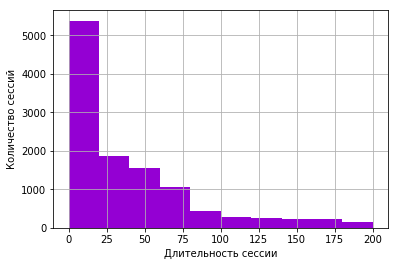

In [17]:
ax = train_data_10users['session_timespan'].hist(range=(0,200), color='darkviolet')
ax.set_xlabel("Длительность сессии");
ax.set_ylabel("Количество сессий");

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

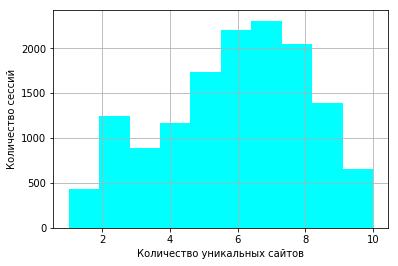

In [18]:
ax = train_data_10users['#unique_sites'].hist(color='aqua')
ax.set_xlabel("Количество уникальных сайтов");
ax.set_ylabel("Количество сессий");

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

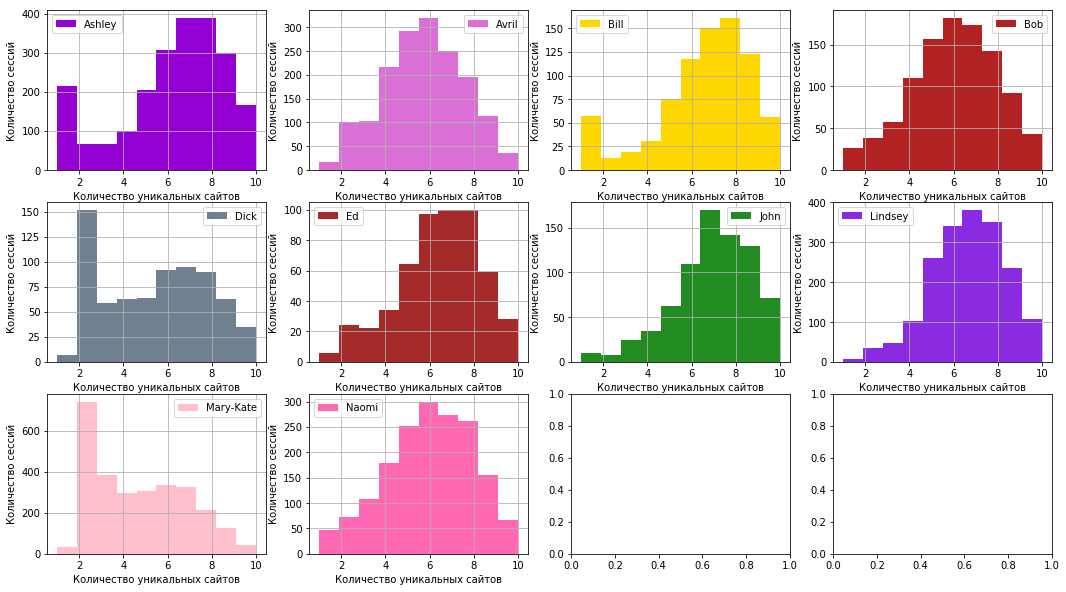

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['#unique_sites'].hist(color=color_dic[user], ax=axes[int(idx/4)][idx%4])
    ax.set_xlabel("Количество уникальных сайтов");
    ax.set_ylabel("Количество сессий");
    ax.legend([user]);

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

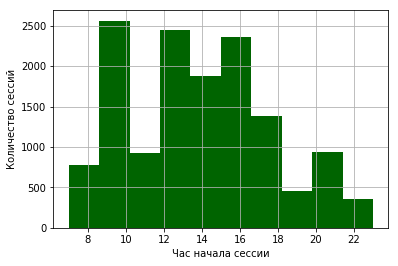

In [20]:
ax = train_data_10users['start_hour'].hist(color='darkgreen')
ax.set_xlabel("Час начала сессии");
ax.set_ylabel("Количество сессий");

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

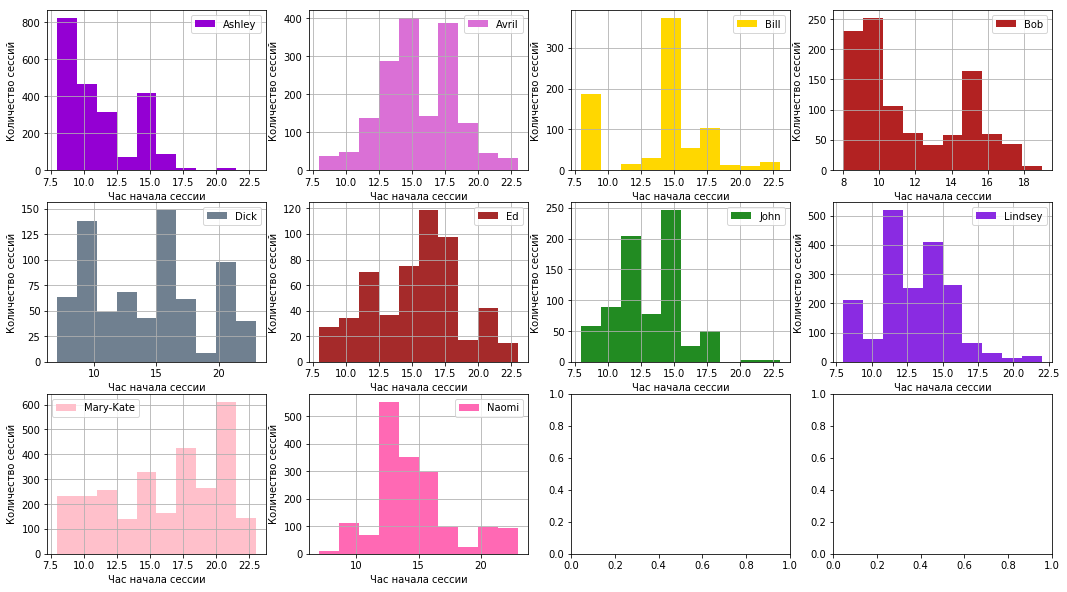

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['start_hour'].hist(color=color_dic[user], ax=axes[int(idx/4)][idx%4])
    ax.set_xlabel("Час начала сессии");
    ax.set_ylabel("Количество сессий");
    ax.legend([user]);

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

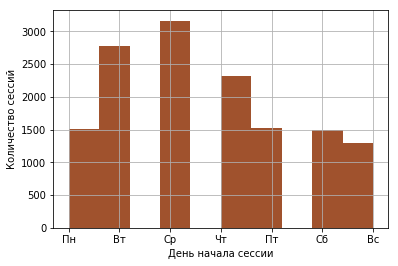

In [22]:
ax = train_data_10users['day_of_week'].hist(color='sienna')
ax.set_xlabel("День начала сессии");
ax.set_ylabel("Количество сессий");
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

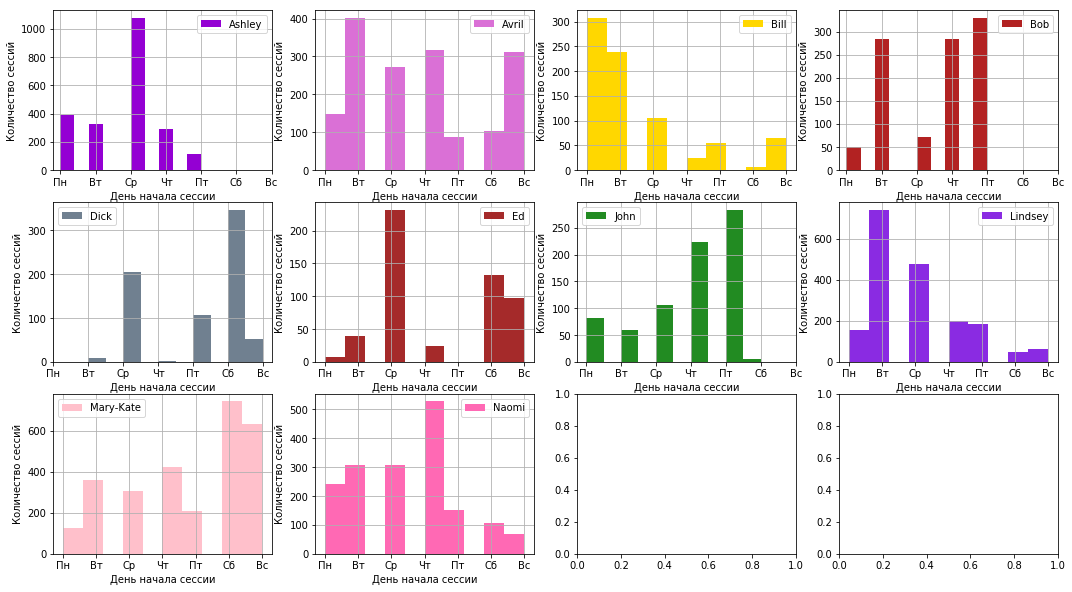

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = sub_df['day_of_week'].hist(color=color_dic[user], ax=axes[int(idx/4)][idx%4])
    ax.set_xlabel("День начала сессии");
    ax.set_ylabel("Количество сессий");
    ax.legend([user]);
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Число уникальных сайтов видится не информативным, как будто это случайная величина, интересно число сайтов из определенной группы (развлекательные, познавательные и т.д.)
Очень много коротких сессий интересно построить процент времени, проводимый пользователем на том или ином сайте от времени его сессии.
Часы начала сессии интересны, однако возможно лучше заменить числом посещения в разные времена дня (утро, день, вечер, ночь, и, как вариант, учесть обеденное время).
Аналогично с днем недели, возможно стоит построить показатели для выходных и не выходных дней (и среднее число визитов для выходных и для рабочих дней).

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as site_freq_pkl:
    sites_dictionary = pickle.load(site_freq_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10 = sorted(sites_dictionary.items(), key= lambda x: x[1][1], reverse= True)[:10]
top10_freqs = list(map(lambda x: x[1][1], top10))
top10_sites = list(map(lambda x: x[0], top10))

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

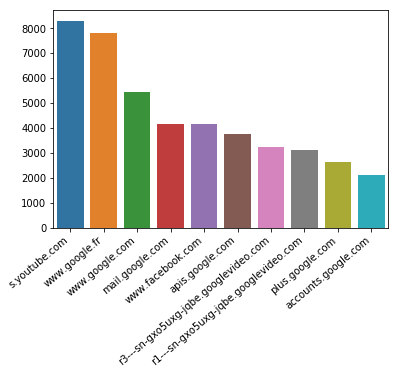

In [26]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [27]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    file_names = glob(os.path.join(path_to_csv_files, '*.csv'))
    file_names.sort()

    with open(site_freq_path, "rb") as site_freq_pkl:
        sites_dictionary = pickle.load(site_freq_pkl)

    data_rows = []
    for file_name in file_names:
        user_id = int(re.findall('user(\d+).csv', file_name)[0])

        with open(file_name, 'r') as file:
            file_lines = list(filter(lambda x: ',' in x, map(lambda x: x.strip(), file.readlines())))[1:]
            line_number = 0
            while line_number < len(file_lines):
                data_row = [0] * len(feature_names)
                data_row[len(feature_names) - 1] = user_id

                i = 0
                session_start_time = None
                session_end_time = None
                previous_operation_time = None
                while (line_number + i) < len(file_lines) and i < session_length:
                    file_line = file_lines[line_number + i].split(',')
                    operation_time = datetime.strptime(file_line[0], "%Y-%m-%d %H:%M:%S")
                    site_name = file_line[1]

                    if (session_start_time is None) or (session_start_time > operation_time):
                        session_start_time = operation_time
                    if (session_end_time is None) or (session_end_time < operation_time):
                        session_end_time = operation_time

                    data_row[i] = sites_dictionary[site_name][0]

                    operation_duration = None
                    if previous_operation_time is not None:
                        operation_duration = int((operation_time - previous_operation_time).total_seconds())
                    previous_operation_time = operation_time
                    if operation_duration is not None:
                        if 'video.' in site_name or 'youtube.' in site_name:
                            data_row[session_length + 5] += operation_duration
                            data_row[session_length + 11] += 1
                        elif 'mail.' in site_name:
                            data_row[session_length + 6] += operation_duration
                            data_row[session_length + 12] += 1
                        elif 'plus.google.' in site_name or 'twitter.' in site_name or 'facebook.' in site_name or 'badoo.' in site_name:
                            data_row[session_length + 7] += operation_duration
                            data_row[session_length + 13] += 1
                        elif 'download.' in site_name or 'javadl-' in site_name:
                            data_row[session_length + 8] += operation_duration
                            data_row[session_length + 14] += 1
                        elif 'wikipedia.' in site_name or 'wikipedia.' in site_name or 'nasa.gov' in site_name:
                            data_row[session_length + 9] += operation_duration
                            data_row[session_length + 15] += 1
                        elif 'www.google.' in site_name or 'bing.' in site_name:
                            data_row[session_length + 9] += operation_duration
                            data_row[session_length + 16] += 1
                        else:
                            data_row[session_length + 10] += operation_duration
                            data_row[session_length + 17] += 1
                    
                    i += 1

                if data_row[0] != 0:
                    data_row[session_length] = int((session_end_time - session_start_time).total_seconds())
                    data_row[session_length + 1] = len(set(filter(lambda x: x != 0, data_row[:session_length])))
                    
                    data_row[session_length + 2] = session_start_time.hour
                    if 22 <= data_row[session_length + 2] <= 24 or 0 <= data_row[session_length + 2] < 8:
                        data_row[session_length + 3] = 1
                    elif 8 <= data_row[session_length + 2] < 10:
                        data_row[session_length + 3] = 2
                    elif 10 <= data_row[session_length + 2] < 13:
                        data_row[session_length + 3] = 3
                    elif 13 <= data_row[session_length + 2] < 15:
                        data_row[session_length + 3] = 4
                    elif 15 <= data_row[session_length + 2] < 19:
                        data_row[session_length + 3] = 5
                    elif 19 <= data_row[session_length + 2] < 22:
                        data_row[session_length + 3] = 6
                        
                    data_row[session_length + 4] = session_start_time.weekday()
                    data_row[session_length + 5] = 1 if data_row[ session_length + 3] == 5 or data_row[session_length + 3] == 6 else 0

                    data_rows.append(data_row)

                line_number += window_size

    return pd.DataFrame(data_rows, columns=feature_names)


In [29]:
feature_names = ['site' + str(i) for i in range(1, 11)] + \
                    ['session_timespan', '#unique_sites', 'start_hour', 'time_of_day',
                     'day_of_week', 'weekend',
                     'video_time', 'mail_time', 'social_networks_time', 'downloading_time', 'education_time', 'search_time', 'other_time',
                     'video_frequency', 'mail_frequency', 'social_networks_frequency', 'downloading_frequency', 'education_frequency', 'search_frequency', 'other_frequency',
                     'user_id']
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                              feature_names=feature_names, session_length=10)

In [30]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                              feature_names=feature_names, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

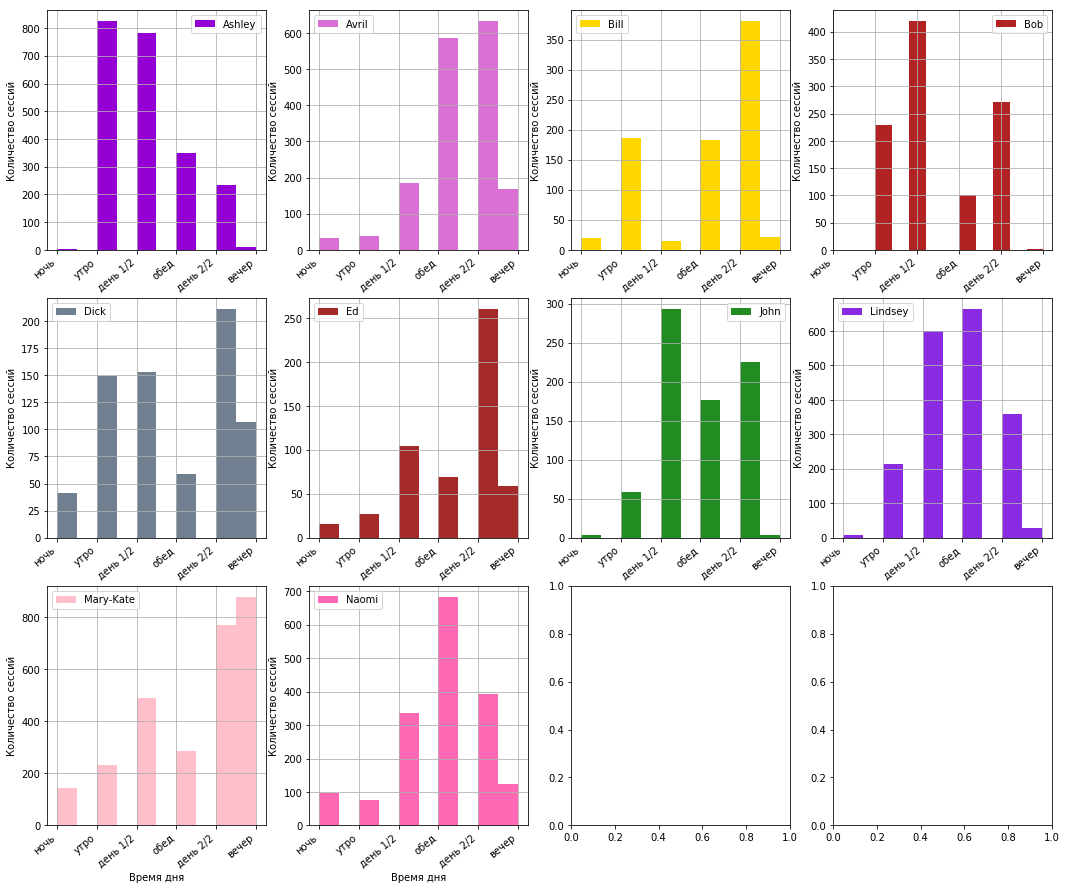

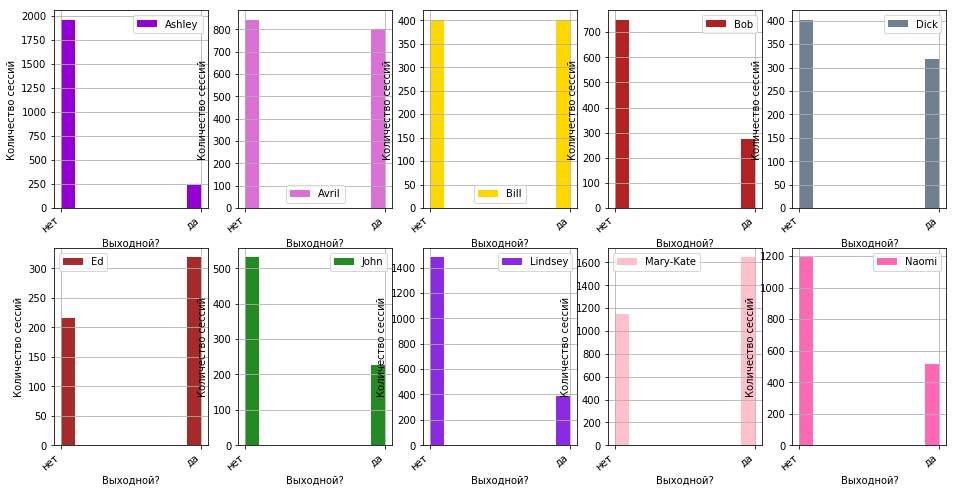

In [31]:
new_features_10users['target'] = new_features_10users['user_id'].map(id_name_dict)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = sub_df['time_of_day'].hist(color=color_dic[user], ax=axes[int(idx/4)][idx%4])
    ax.set_xlabel("Время дня");
    ax.set_ylabel("Количество сессий");
    ax.legend([user]);
    ax.set_xticks([1, 2, 3, 4, 5, 6]);
    ax.set_xticklabels(['ночь', 'утро', 'день 1/2', 'обед', 'день 2/2', 'вечер'], rotation=40, ha="right", fontsize=10);
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = sub_df['weekend'].hist(color=color_dic[user], ax=axes[int(idx/5)][idx%5])
    ax.set_xlabel("Выходной?");
    ax.set_ylabel("Количество сессий");
    ax.legend([user]);
    ax.set_xticks([0, 1]);
    ax.set_xticklabels(['нет', 'да'], rotation=40, ha="right", fontsize=10);


**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

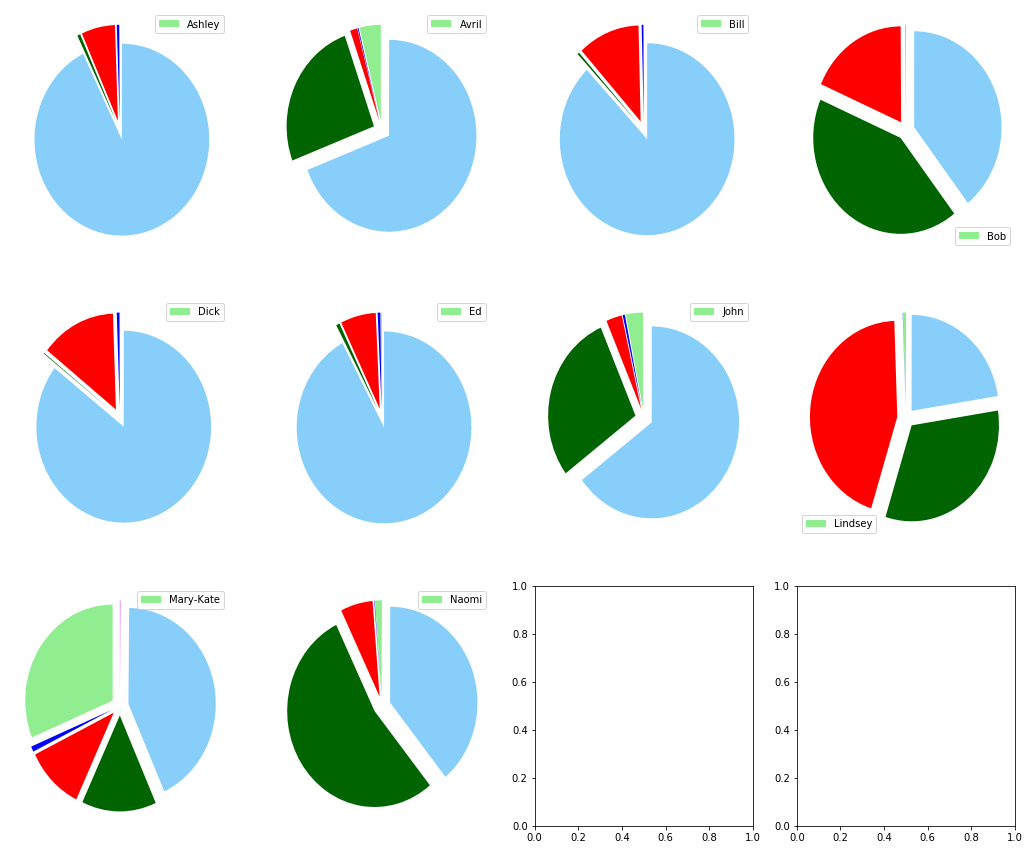

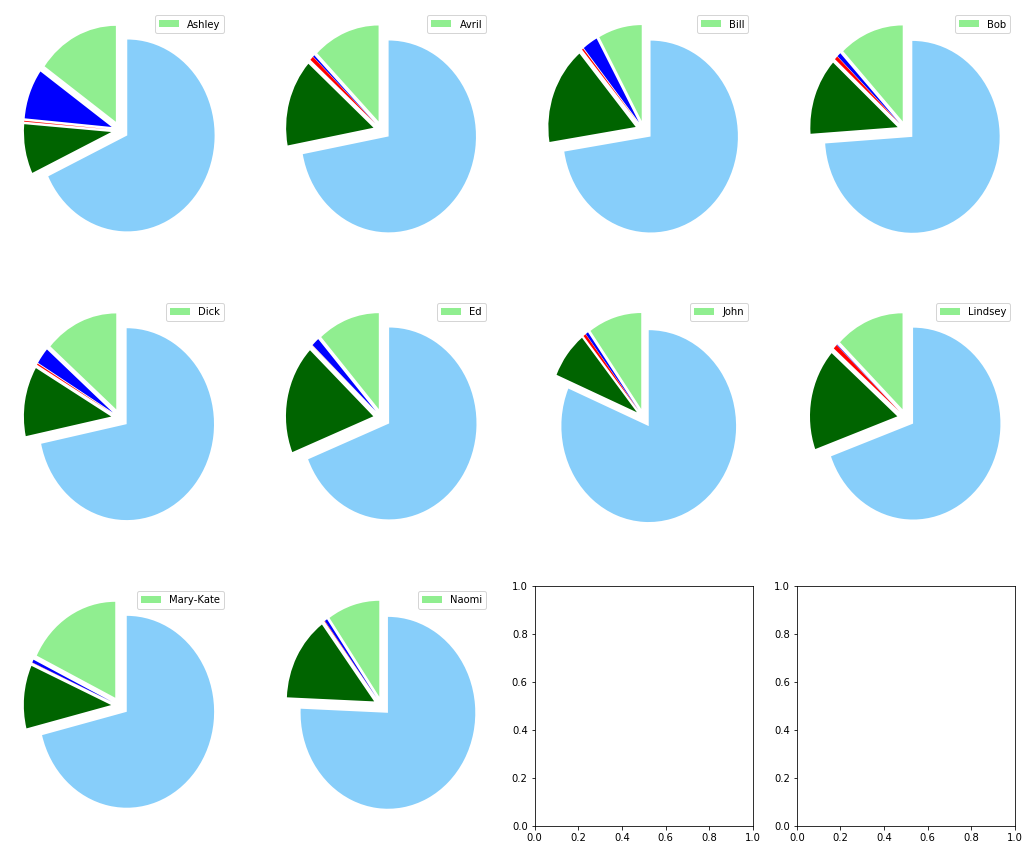

In [32]:
colors = ['lightgreen', 'blue', 'red', 'darkgreen', 'lightskyblue', 'violet', 'black']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[int(idx/4)][idx%4].pie([sub_df['video_time'].mean(), sub_df['mail_time'].mean(), sub_df['social_networks_time'].mean(), sub_df['downloading_time'].mean(), sub_df['education_time'].mean(), sub_df['search_time'].mean(), sub_df['other_time'].mean()],
                                colors=colors, explode=explode, startangle=90, rotatelabels =True)
    axes[int(idx/4)][idx%4].legend([user]);
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
    axes[int(idx/4)][idx%4].pie([sub_df['video_frequency'].mean(), sub_df['mail_frequency'].mean(), sub_df['social_networks_frequency'].mean(), sub_df['downloading_frequency'].mean(), sub_df['education_frequency'].mean(), sub_df['search_frequency'].mean(), sub_df['other_frequency'].mean()],
                                colors=colors, explode=explode,startangle=90, rotatelabels =True)
    axes[int(idx/4)][idx%4].legend([user]);

selected_features_10users = new_features_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'time_of_day', 'weekend', 
                                                  'video_time', 'mail_time', 'social_networks_time', 'downloading_time', 'education_time', 'search_time', 'other_time', 
                                                  'video_frequency', 'mail_frequency', 'social_networks_frequency', 'downloading_frequency', 'education_frequency', 'search_frequency', 'other_frequency']]
selected_features_150users = new_features_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'time_of_day', 'weekend', 
                                                  'video_time', 'mail_time', 'social_networks_time', 'downloading_time', 'education_time', 'search_time', 'other_time', 
                                                  'video_frequency', 'mail_frequency', 'social_networks_frequency', 'downloading_frequency', 'education_frequency', 'search_frequency', 'other_frequency']]

In [33]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 